In [1]:
import pandas as pd 
import geopandas
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import Colormap as cm
from sklearn import preprocessing

This notebook is based on The Mental Disorders Dataset. After deep data cleaning, we perform a careful analysis of the dataset and present detailed questions and insights about it.

In [2]:
# Data source: https://ourworldindata.org/ 

# Data provided by https://www.kaggle.com/datasets/thedevastator/uncover-global-trends-in-mental-health-disorder

In [3]:
data = pd.read_csv('Data.csv', low_memory=False) # Loading Data

# Data Cleaning and First Inspections

Let us take a look at what our data looks like:

In [4]:
data.head()

,index,Entity,Code,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
0,0,Afghanistan,AFG,1990,0.16056,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404
1,1,Afghanistan,AFG,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768
2,2,Afghanistan,AFG,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644
3,3,Afghanistan,AFG,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738
4,4,Afghanistan,AFG,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260


This data is divided in 4 tables, which we can see by looking for the cells with value Year:

In [5]:
data[data['Year'] == 'Year'] # 4 tables

,index,Entity,Code,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
6468,6468,Entity,Code,Year,Prevalence in males (%),Prevalence in females (%),Population,NaN,NaN,NaN,NaN
54276,54276,Entity,Code,Year,"Suicide rate (deaths per 100,000 individuals)",Depressive disorder rates (number suffering pe...,Population,NaN,NaN,NaN,NaN
102084,102084,Entity,Code,Year,Prevalence - Depressive disorders - Sex: Both ...,NaN,NaN,NaN,NaN,NaN,NaN


Now we will extract all 4 tables:

In [6]:
#Dividing tables 

table1 = data.iloc[:6468]

table2 = data.iloc[6469:54276]
table2.columns = data.iloc[6468]
table2 = table2.iloc[:,:7].drop(columns = 6468)

table3 = data.iloc[54277:102084]
table3.columns = data.iloc[54276]
table3 = table3.iloc[:,:7].drop(columns = 54276)

table4 = data.iloc[102085:]
table4.columns = data.iloc[102084]
table4 = table4.iloc[:,:5].drop(columns = 102084)


### Summary of tables

Table1:

- Entity (Country) & Code
- Year 
- Relative Disorders (%) (% value of disorders relative to population)

* We will sometimes omit the word relative when refering to the values on this table

Table 2:

- Prevalence in males/females (%) (% value of males/females with disorders relative to population)
- Population

Table 3:

- Suicide rate (deaths per 100,000 individuals)	
- Depressive disorder rates (number suffering per 100,000)

Table 4:

- Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Number) (people suffering from depression)

If we check the data type, we will see that some values which were supposed to be floats are actually strings:

In [7]:
table1.dtypes

index                          int64
Entity                        object
Code                          object
Year                          object
Schizophrenia (%)             object
Bipolar disorder (%)          object
Eating disorders (%)          object
Anxiety disorders (%)        float64
Drug use disorders (%)       float64
Depression (%)               float64
Alcohol use disorders (%)    float64
dtype: object

We will tranform these data types to the correct form, filter the years to retain only those between 1990-2017, as well as the countries that are not present in the first table. By doing this, we will be able to merge all tables together:

In [8]:
dtypes1 = {'Schizophrenia (%)': 'float', 'Bipolar disorder (%)': 'float', 'Year': 'int', 'Eating disorders (%)' : 'float'}

table1 = table1.astype(dtypes1)

table2 = table2[(table2.Year.isin(table1.Year.unique().astype(str))) & (table2.Entity.isin(table1.Entity.unique()))] #Year is a str because of wrong dates
dtypes2 = {'Prevalence in males (%)': 'float', 'Prevalence in females (%)': 'float', 'Year': 'int', 'Population' : 'float'}
table2 = table2.astype(dtypes2)

table3 = table3[(table3.Year.isin(table1.Year.unique().astype(str))) & (table3.Entity.isin(table1.Entity.unique()))]
dtypes3 = {'Suicide rate (deaths per 100,000 individuals)': 'float', 'Depressive disorder rates (number suffering per 100,000)': 'float', 'Year': 'int', 'Population' : 'float'}
table3 = table3.astype(dtypes3)

table4 = table4[(table4.Year.isin(table1.Year.unique().astype(str))) & (table4.Entity.isin(table1.Entity.unique()))]
dtypes4 = {'Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Number) (people suffering from depression)': 'float', 'Year' : 'int'}
table4 = table4.astype(dtypes4)

We merge the tables, and rename some columns:

In [9]:
# Merging all tables 

table = table1.merge(table2, on=['Entity', 'Year','Code'])
table = table.merge(table3, on=['Entity', 'Year','Code'])
table = table.merge(table4, on=['Entity', 'Year','Code'])

table = table.drop(columns= ['Population_y','index'])
table = table.rename(columns={'Population_x': 'Population','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Number) (people suffering from depression)': 'People suffering from depression'})

Inside this dataset there is a set of rows that represent regions, not countries. We will remove this set from the data and create a separate dataset for it:

In [10]:
extra = table[table.Entity.isin(['World','High SDI', 'High-income', 'High-middle SDI', 'Low SDI', 'Low-middle SDI',  'Middle SDI', 'Western Europe',
'Tropical Latin America', 'Sub-Saharan Africa', 'Sub-Saharan Africa', 'Southern Sub-Saharan Africa','Southeast Asia, East Asia, and Oceania', 
'Southern Latin America','Southeast Asia','Latin America and Caribbean', 'Eastern Sub-Saharan Africa','Eastern Europe','East Asia','Central Latin America',
 'Central Sub-Saharan Africa','Central Europe, Eastern Europe, and Central Asia','Central Asia', 'Central Europe', 'High-income Asia Pacific', 'Andean Latin America'])]
index = extra.index

table = table.drop(index)



# Data Discussion

There are many hidden variables on this dataset that cannot be measured but can be of high influence to its behavior. Some of these variables are:

- Disorders Awareness: It is a well known fact that mental health awareness is on the rise. This would mean that more people are being diagnosed because of the availability and social acceptance of these diagnoses. This variable could give the wrong impression that in the past there were less people with mental disorders.

- Availability/Quality of Doctors: To be on this dataset, the person has to have been diagnosed by a certified doctor. In different countries and time periods, the availability of doctors, and the quality of their diagnoses, fluctuates.

- Local Cultures

Given that we don't have control of the dataset source in each country, and because of the above variables, the analysis provided by this notebook is only a Toy Analysis, and doesn't reflect reality.


# Data Analyze

### Disorders Linear Correlation

A simple initial question is if there is any dependence between the various types of disorders. The most simple way to verify this is to compute the linear correlation between the disorders. It is important to notice that linear correlation doesn't actually imply dependence, and also fails to show non-linear relationships. 

In [11]:
table[table.columns[3:10]].corr()

,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
Schizophrenia (%),1.000000,0.274331,0.709423,0.509071,0.467557,0.186910,-0.030597
Bipolar disorder (%),0.274331,1.000000,0.720182,0.664853,0.382433,0.158623,0.062718
Eating disorders (%),0.709423,0.720182,1.000000,0.695538,0.483485,0.248503,0.043993
Anxiety disorders (%),0.509071,0.664853,0.695538,1.000000,0.619337,0.378721,-0.143054
Drug use disorders (%),0.467557,0.382433,0.483485,0.619337,1.000000,0.368373,-0.122235
Depression (%),0.186910,0.158623,0.248503,0.378721,0.368373,1.000000,0.047131
Alcohol use disorders (%),-0.030597,0.062718,0.043993,-0.143054,-0.122235,0.047131,1.000000


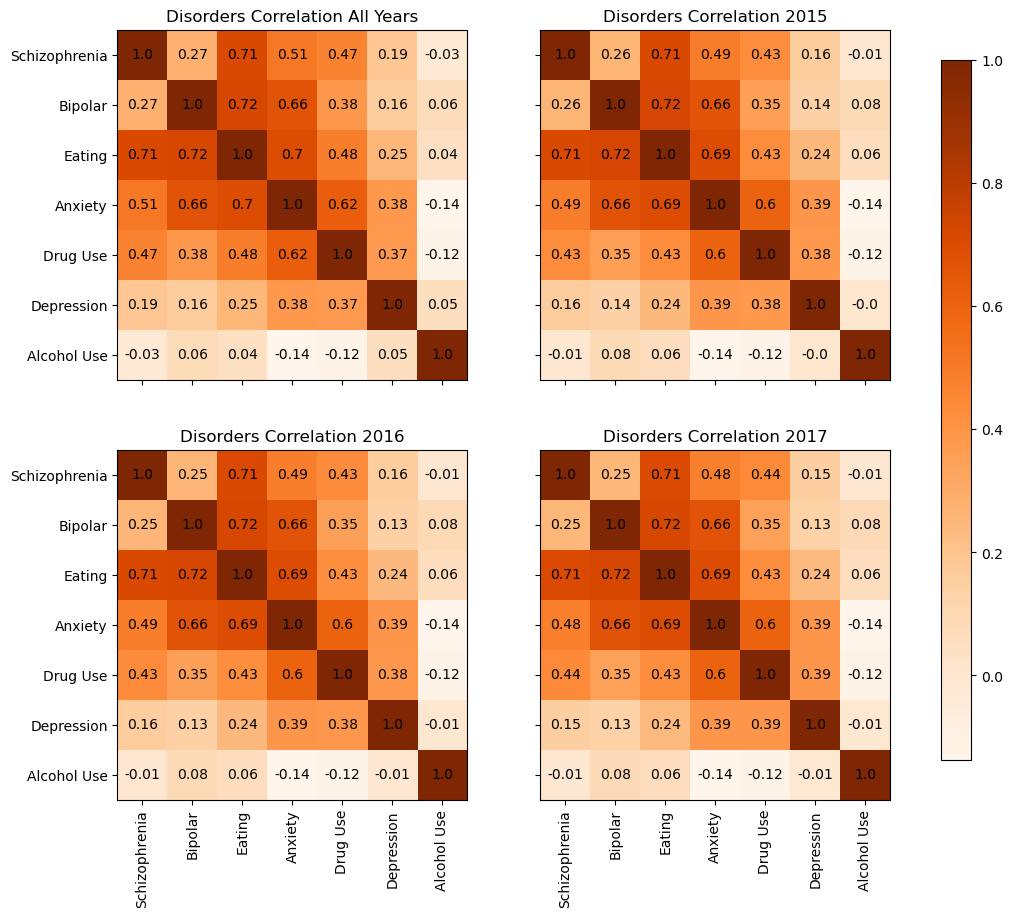

In [12]:
#Plotting correlations 

corr = table[table.columns[3:10]].corr() #Correlation over all countries and all years 

index = ['Schizophrenia', 'Bipolar', 'Eating', 'Anxiety', 'Drug Use', 'Depression', 'Alcohol Use']
# corr['index'] = index
# x = (corr.columns,index)
# x = set(zip(x[0],x[1]))
# d = {a:b for (a,b) in x}
# corr = corr.set_index('index', drop=True)
# corr.index.name = None
# corr = corr.rename(columns = d)

fig, ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey= True);

im = ax[0,0].imshow(corr, cmap='Oranges');

ax[0,0].xaxis.set_ticks([0,1,2,3,4,5,6])
ax[0,0].yaxis.set_ticks([0,1,2,3,4,5,6])
ax[0,0].set_xticklabels(index, rotation=90, minor = False);
ax[0,0].set_yticklabels(index,);
ax[0,0].set_title('Disorders Correlation All Years')

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax[0,0].text(j, i, round(corr.to_numpy()[i, j], 2),
                       ha="center", va="center", color="black")

corr = table[table['Year'] == 2015][table.columns[3:10]].corr()

im = ax[0,1].imshow(corr, cmap='Oranges');

ax[0,1].xaxis.set_ticks([0,1,2,3,4,5,6])
ax[0,1].yaxis.set_ticks([0,1,2,3,4,5,6])
ax[0,1].set_xticklabels(index, rotation=90, minor = False);
ax[0,1].set_yticklabels(index,);
ax[0,1].set_title(f'Disorders Correlation {2015}')

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax[0,1].text(j, i, round(corr.to_numpy()[i, j], 2),
                       ha="center", va="center", color="black")


for k in range(2):
    corr = table[table['Year'] == 2016 + k][table.columns[3:10]].corr()
    im = ax[1,k].imshow(corr, cmap='Oranges');

    ax[1,k].xaxis.set_ticks([0,1,2,3,4,5,6])
    ax[1,k].yaxis.set_ticks([0,1,2,3,4,5,6])
    ax[1,k].set_xticklabels(index, rotation=90, minor = False);
    ax[1,k].set_yticklabels(index,);
    ax[1,k].set_title(f'Disorders Correlation {2016 + k}')

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = ax[1,k].text(j, i, round(corr.to_numpy()[i, j], 2),
                        ha="center", va="center", color="black")

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)


plt.show();

We see that the correlation matrix is very similar for 2015, 2016, 2017, and the All Years matrix. We also see that the disorders seem to be correlated, with the exception of Alcohol Use.

It is evident that the disorder pairs with the most correlation are Eating Disorder - Bipolar Disorder and Eating Disorder - Anxiety.

If we look for the disorders with highest correlation to the others, we see that Eating Disorders and Anxiety Disorders are the ones with biggest correlation to the other disorders, with mean values larger than 0.5.

In [13]:
corr = table[table.columns[3:10]].corr()  
corr.mean(axis=1).sort_values(ascending=False)

Eating disorders (%)         0.557303
Anxiety disorders (%)        0.532067
Bipolar disorder (%)         0.466163
Drug use disorders (%)       0.456993
Schizophrenia (%)            0.445242
Depression (%)               0.341180
Alcohol use disorders (%)    0.122565
dtype: float64

We can plot Eating Disorder X Bipolar Disorder/Anxiety Disorder to see their correlation. 

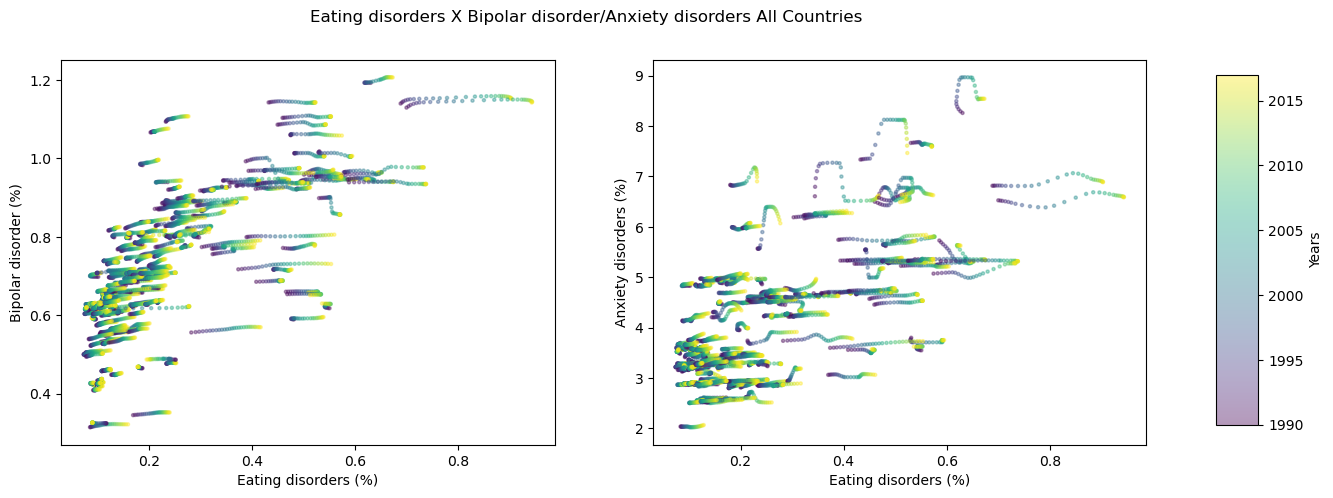

In [14]:
fig, ax = plt.subplots(1,2, figsize = (14,5), sharex=True)

im = ax[0].scatter(table['Eating disorders (%)'], table['Bipolar disorder (%)'], c=table['Year'], s= 5, alpha= 0.4);
im = ax[1].scatter(table['Eating disorders (%)'], table['Anxiety disorders (%)'], c=table['Year'], s= 5, alpha= 0.4);
ax[0].set_xlabel('Eating disorders (%)')
ax[0].set_ylabel('Bipolar disorder (%)')
ax[1].set_xlabel('Eating disorders (%)')
ax[1].set_ylabel('Anxiety disorders (%)')

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'Years')
plt.suptitle('Eating disorders X Bipolar disorder/Anxiety disorders All Countries');



Let's select a specific country to look at this topic a little bit closer:

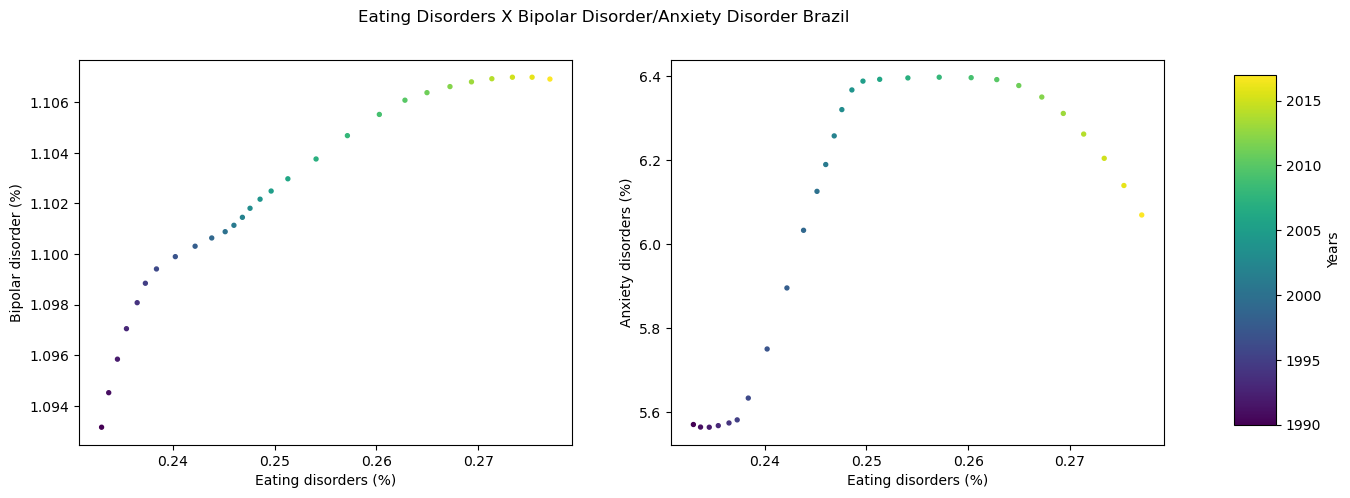

In [15]:
fig, ax = plt.subplots(1,2, figsize = (14,5), sharex=True)

brazil = table[table.Entity.isin(['Brazil'])]

im = ax[0].scatter(brazil['Eating disorders (%)'], brazil['Bipolar disorder (%)'], c=brazil['Year'], s= 8, alpha= 1);
im = ax[1].scatter(brazil['Eating disorders (%)'], brazil['Anxiety disorders (%)'], c=brazil['Year'], s= 8, alpha= 1);
ax[0].set_xlabel('Eating disorders (%)')
ax[0].set_ylabel('Bipolar disorder (%)')
ax[1].set_xlabel('Eating disorders (%)')
ax[1].set_ylabel('Anxiety disorders (%)')

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'Years')
plt.suptitle('Eating Disorders X Bipolar Disorder/Anxiety Disorder Brazil');

From the two graphs above we can, in fact, check the correlation between Eating Disorder and Bipolar Disorder/Anxiety Disorder. With a quick search online, we verify that, "If you have bipolar disorder, it’s common to also have an eating disorder. A systematic review from 2019 reported that eating disorders affect up to a third of people with bipolar disorder (33%)... Eating disorders may occur more frequently in bipolar disorder because of the symptoms of depression, mania, and hypomania — all of which can affect your appetite and eating habits."(https://psychcentral.com/bipolar/bipolar-disorder-and-eating-disorders#whats-the-link)

 The correlations seem to be almost linear in most of the countries (the most linear is between Eating Disorder and Bipolar Disorder). By looking at the colorplot, we can also see that there must be a correlation between Time (Years), and Disorders. We can verify if this correlation is linear: 

In [16]:
corr = table[table.columns[2:10]].corr()  
corr['Year']

Year                         1.000000
Schizophrenia (%)            0.038898
Bipolar disorder (%)         0.011575
Eating disorders (%)         0.085078
Anxiety disorders (%)        0.011261
Drug use disorders (%)       0.058545
Depression (%)              -0.033156
Alcohol use disorders (%)    0.018860
Name: Year, dtype: float64

According to the table above, the correlation between Disorders and Years is probably non-linear. We can visualize this by plotting a Disorder x Years graph:

In [17]:
# To fit all curves in the graph, we first need to normalize the data: 

mean = table[table.columns[3:10]].mean(axis=0)
std = table[table.columns[3:10]].std(axis=0)
norm = (table[table.columns[3:10]] - mean)/std
norm = pd.concat([table['Year'],norm], axis = 1)

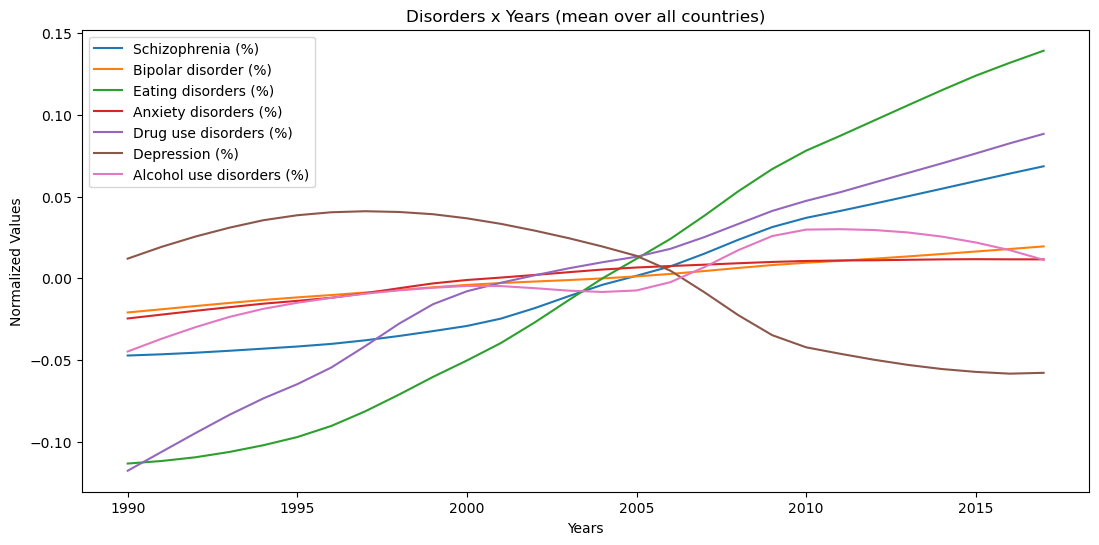

In [18]:
norm.groupby('Year').mean().plot(figsize=(13,6), title='Disorders x Years (mean over all countries)', ylabel = 'Normalized Values', xlabel = 'Years');

In fact, we see that the Disorders, with exception of Depression and Alcohol Use, present such a slow growth (small curvature) that they can be very well aproximated by a straight line of small coeficient.

Although the percentage of people with Depression is not growing, if we look for the avarege of people with depression in each year, we will see that it is grows with time:

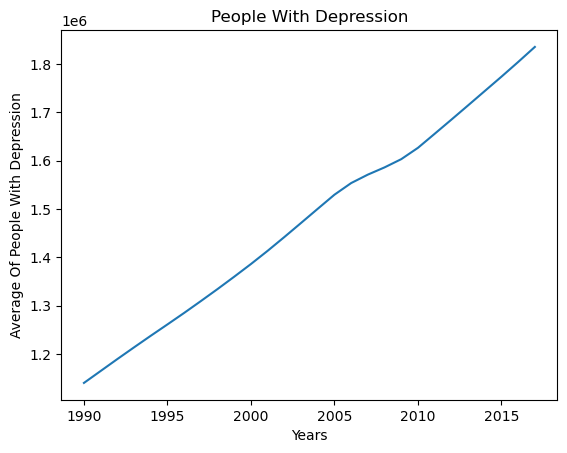

In [19]:
avgdep = table.groupby('Year').mean(numeric_only=True)
avgdep['People suffering from depression'].plot(title = 'People With Depression',  xlabel = 'Years', ylabel = 'Average Of People With Depression' );

Another piece of the data the we would like to look at is the Suicide Rate:

In [20]:
table[table.columns[2:]].drop(['Prevalence in males (%)','Prevalence in females (%)','Population'], axis= 1).corr()['Suicide rate (deaths per 100,000 individuals)'].sort_values(ascending=False)

Suicide rate (deaths per 100,000 individuals)               1.000000
Alcohol use disorders (%)                                   0.468581
Depression (%)                                              0.393676
Depressive disorder rates (number suffering per 100,000)    0.393253
People suffering from depression                            0.025856
Schizophrenia (%)                                           0.020274
Eating disorders (%)                                       -0.056553
Drug use disorders (%)                                     -0.071900
Year                                                       -0.108712
Anxiety disorders (%)                                      -0.133561
Bipolar disorder (%)                                       -0.277022
Name: Suicide rate (deaths per 100,000 individuals), dtype: float64

The correlation table above shows us that the Suicide Rate shows linear correlation with Alcohol Use and Depression.

We can now look for the countries with the highest Suicide rates:

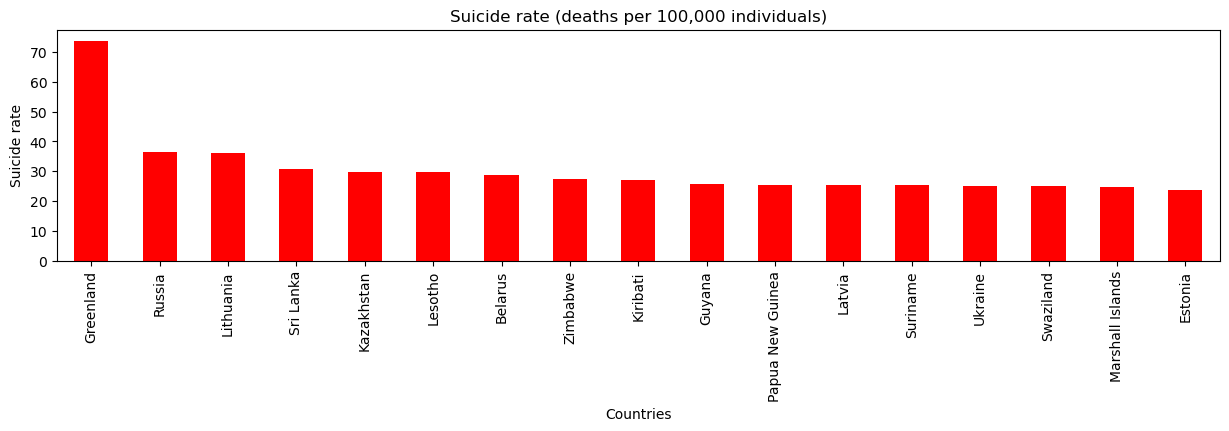

In [21]:
table.groupby(['Entity']).mean(numeric_only = True).sort_values('Suicide rate (deaths per 100,000 individuals)', ascending = False)['Suicide rate (deaths per 100,000 individuals)'][:17].plot.bar(color='red', figsize=(15,3), title='Suicide rate (deaths per 100,000 individuals)', ylabel = 'Suicide rate', xlabel='Countries');

Greenland has the highest suicide rate in the world. This is in fact true: "According to suicide data published by Statistics Greenland, suicide accounts for 8% of total deaths in Greenland and is the leading cause of death among young men aged 15–29"(https://en.wikipedia.org/wiki/Suicide_in_Greenland).

Now let's do the same for Alcohol Use and Depression:

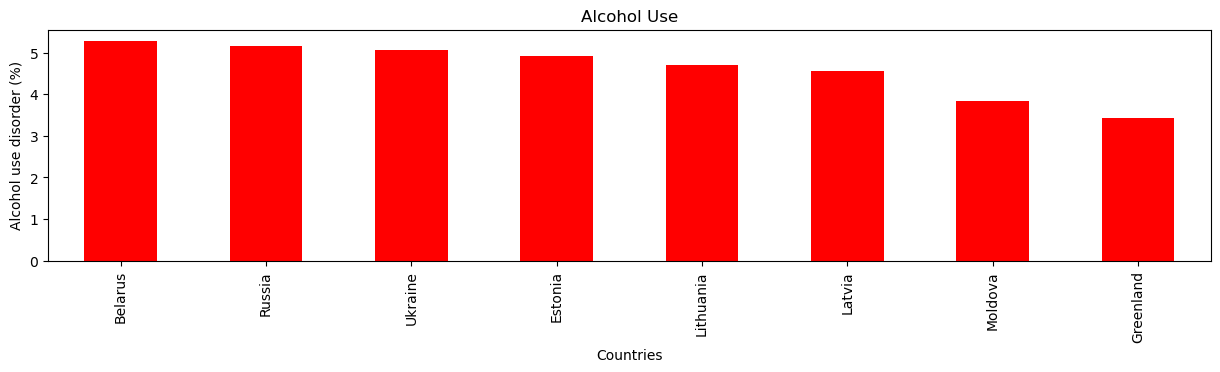

In [22]:
table.groupby(['Entity']).mean(numeric_only = True).sort_values('Alcohol use disorders (%)', ascending = False)['Alcohol use disorders (%)'][:8].plot.bar(color='red', figsize=(15,3), title='Alcohol Use', ylabel = 'Alcohol use disorder (%)', xlabel='Countries');

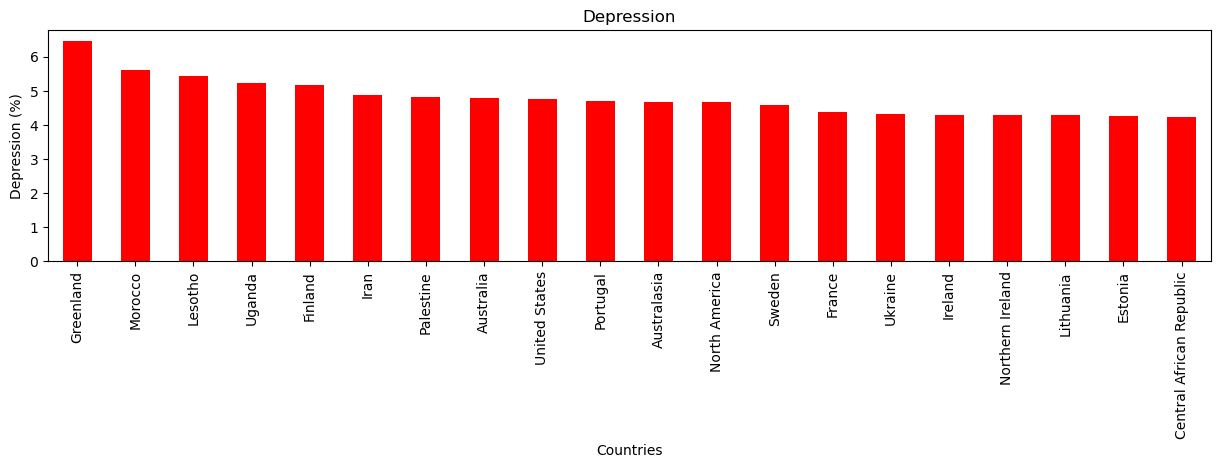

In [23]:
table.groupby(['Entity']).mean(numeric_only = True).sort_values('Depression (%)', ascending = False)['Depression (%)'][:20].plot.bar(color='red', figsize=(15,3), title='Depression', ylabel = 'Depression (%)', xlabel='Countries');

We see a big intersection between all the above graphs.

The last columns left to explore are Prevalence in males (%) and Prevalence in females (%). We can look for the countries with biggest prevalence in males, and compare with prevalence in females:

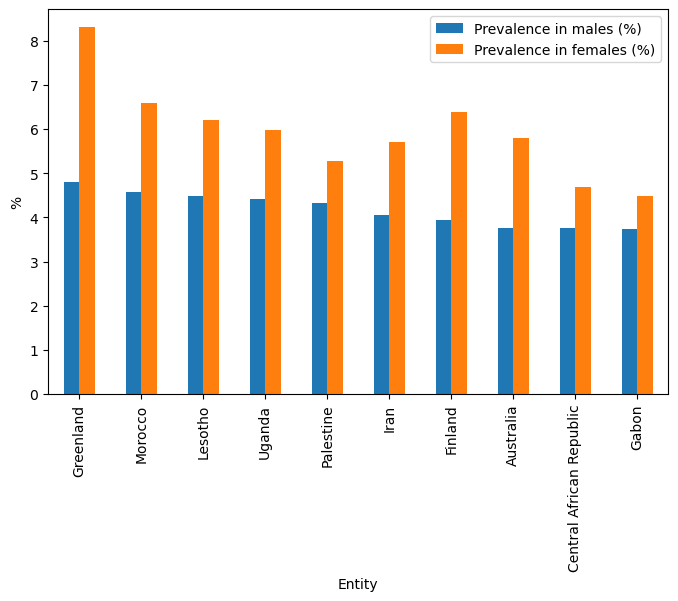

In [26]:
table.groupby('Entity').mean(numeric_only = True)[['Prevalence in males (%)','Prevalence in females (%)']].sort_values('Prevalence in males (%)', ascending = False)[:10].plot.bar(ylabel= ('%'), figsize = (8,5));

It seems that females tend to have the highest prevalance in mental disorders. We can also compute the mean of these two columns over all years and countries:

In [27]:
table.describe()[['Prevalence in males (%)','Prevalence in females (%)']].iloc[1]

Prevalence in males (%)      2.815223
Prevalence in females (%)    4.160527
Name: mean, dtype: float64

In fact, the average of females with mental disorder is almost 1.5 times higher than males (in %). This could be explained by the common idea that women care more about their health, and consequentially go to see a doctor more often than men. It can also be explained by the idea that mental disorders are a bigger taboo between men than between women. This discussion is part of the hidden variables that we talked about in the beginning.

We can ask if the gap seen between male and female prevalence changes over time. There are two explanations that I believed would cause this gap to decrease:

- I believe that females used to be misdiagnosed with mental disorders much more than men.
- The taboo concerning mental disorders in males seems like it would decrease with time and awareness of mental health issues.

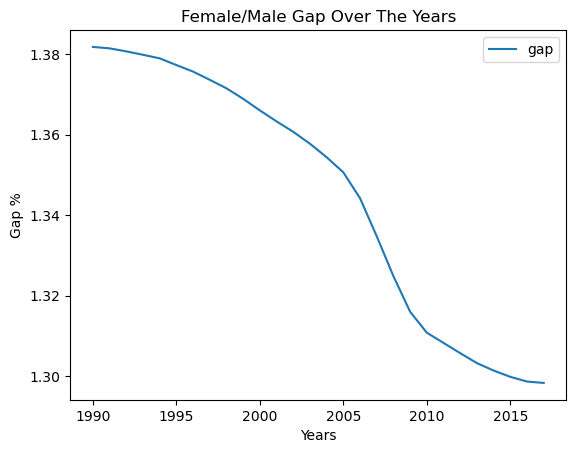

In [28]:
gap = table
gap['gap'] = np.abs(table['Prevalence in females (%)'] - table['Prevalence in males (%)'])
gap.groupby('Year').mean(numeric_only=True)[['gap']].plot(title = 'Female/Male Gap Over The Years', xlabel = 'Years', ylabel = 'Gap %');

We see that the gap is becoming smaller over the years.

When we have global data like this, it is common to look for a correlation with social-economical measures. To do so, we will import the following dataset of HDI (Human Development Index):

In [29]:
hdi = pd.read_csv('human-development-index.csv')

hdi = hdi[hdi['Year']<= 2017].reset_index(drop=True) #select same years from original dataset

In [30]:
# Some countries are we different sames

change = {'Czechia': 'Czech Republic','Eswatini': 'Swaziland', 'South Asia (UNDP)': 'South Asia' }
hdi = hdi.replace({'Entity':change})

In [31]:
hdi = hdi[~hdi.Entity.isin(hdi.Entity.unique()[~np.in1d(hdi.Entity.unique(),table.Entity.unique())])] #We select only the countries that are also in the original dataset

In [32]:
tablehdi = hdi.merge(table)  #merge both dataset

Now let's look for linear correlation:

In [33]:
hdicorr = tablehdi.drop(columns=['Year','Population','Prevalence in males (%)','Prevalence in females (%)','Code','People suffering from depression','Depressive disorder rates (number suffering per 100,000)']).corr( numeric_only= True)['Human Development Index'].sort_values(ascending=False)
hdicorr

Human Development Index                          1.000000
Eating disorders (%)                             0.760082
Schizophrenia (%)                                0.662839
Bipolar disorder (%)                             0.568743
Anxiety disorders (%)                            0.480913
Drug use disorders (%)                           0.413050
gap                                              0.231066
Alcohol use disorders (%)                        0.200159
Depression (%)                                  -0.037787
Suicide rate (deaths per 100,000 individuals)   -0.055146
Name: Human Development Index, dtype: float64

We see that the HDI has a high correlation with Eating Disorders. It also has a low correlation with Depression and Suicide Rate.

It is worth mentioning again the hidden variables... It is very likely that countries with bigger HDI also offer more accessibility to doctors able to perform mental health evaluations, as well as many other factors influencing individuals to seek help. This could explain the high levels for the correlations. We can plot the same bar plot as before:

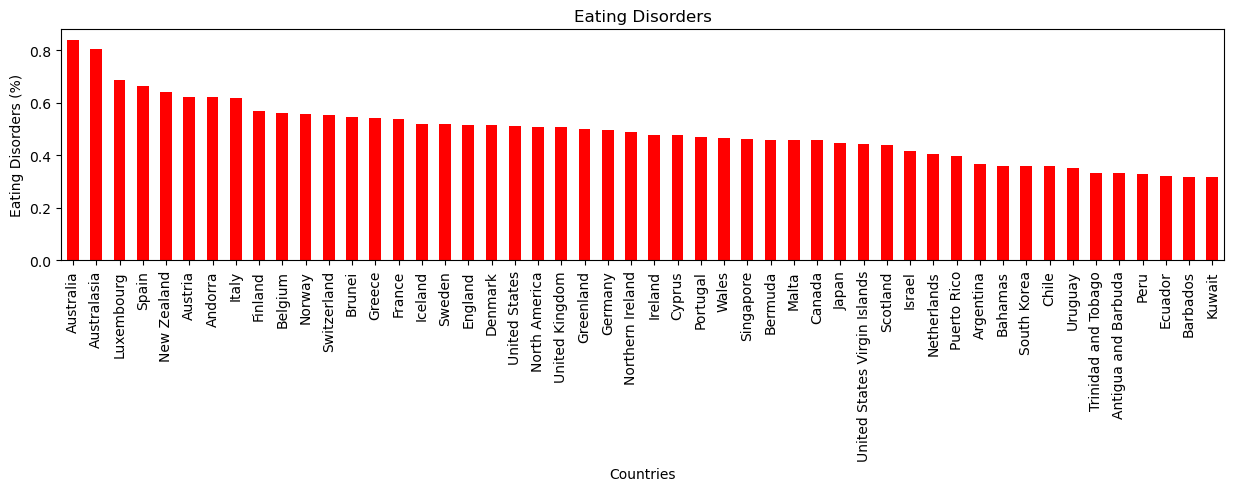

In [34]:
table.groupby(['Entity']).mean(numeric_only = True).sort_values('Eating disorders (%)', ascending = False)['Eating disorders (%)'][:50].plot.bar(color='red', figsize=(15,3), title='Eating Disorders', ylabel = 'Eating Disorders (%)', xlabel='Countries');

We can also make a scatter plot (HDI x Eating Disorder All Countries):

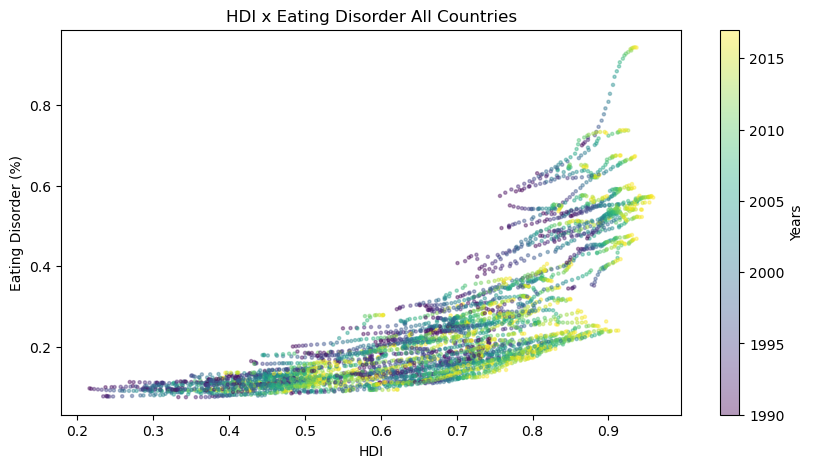

In [35]:
plt.figure(figsize= (10,5))
plt.scatter(tablehdi['Human Development Index'], tablehdi['Eating disorders (%)'], c=tablehdi['Year'], s= 5, alpha= 0.4)
plt.title('HDI x Eating Disorder All Countries')
plt.xlabel('HDI')
plt.ylabel('Eating Disorder (%)')
plt.colorbar(label = 'Years');

We can see some kind of exponential relation between HDI and Eating Disorder, but as we have discussed, this doesn't mean much.

We can see if the HDI will affect the gap between prevalence in females/males

In [36]:
prevalence = tablehdi[['Entity','Prevalence in females (%)', 'Prevalence in males (%)' , 'Human Development Index']].groupby('Entity').mean().sort_values('Human Development Index', ascending=False)

In [37]:
prevalence.corr()

,Prevalence in females (%),Prevalence in males (%),Human Development Index
Prevalence in females (%),1.000000,0.793992,0.029382
Prevalence in males (%),0.793992,1.000000,-0.175668
Human Development Index,0.029382,-0.175668,1.000000


It seems that there is no linear correlation between the gap and HDI. We can plot the 10 countries with bigger/lower HDI to verify this.

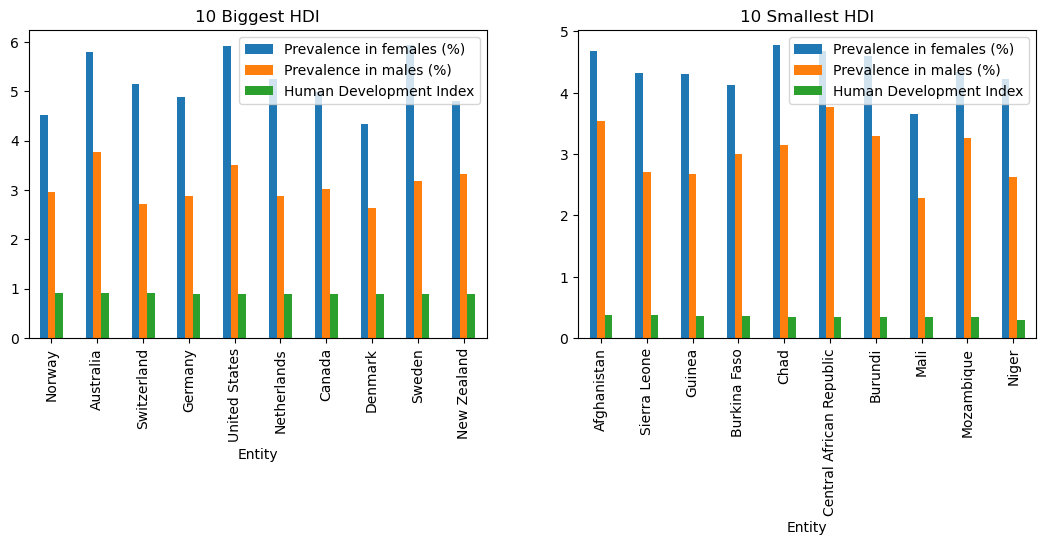

In [38]:
fig, ax = plt.subplots(1,2, figsize= (13,4))

prevalence[:10].plot.bar(ax=ax[0])
prevalence[-10:].plot.bar(ax=ax[1]);
ax[0].set_title('10 Biggest HDI')
ax[1].set_title('10 Smallest HDI');

To end our analysis, we will represent some of our graphs in a map. This will help us visualize the data (for 2017). To help with this, let's import the module geopandas:

In [39]:
geo = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

We have to perform some data cleaning, so that the date from geopandas will match the data from table:

In [40]:
inworld = np.in1d(geo.iso_a3.sort_values().unique(),gap.Code.sort_values().unique())

miss = geo.iso_a3.sort_values().unique()[~inworld] # Codes that are in the geo dataset, and are not in table

geo[geo.iso_a3.isin(miss)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
20,3398.0,South America,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."
23,140.0,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940..."
134,287800.0,Oceania,New Caledonia,NCL,10770,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7..."
159,4490.0,Antarctica,Antarctica,ATA,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140..."
160,326000.0,Asia,N. Cyprus,CYN,3600,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,5096159.0,Africa,Somaliland,SOL,17836,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [41]:
# Matching codes 

index = gap[gap.Entity.isin(['Western Sub-Saharan Africa'])].index
change = {'CYP': 'CYN'}

tablegeo = gap.replace({'Code':change})

for i in index:
    tablegeo.at[i,'Code'] = 'ESH'
    
tablegeo = geo.merge(tablegeo[tablegeo['Year'] == 2017], left_on = 'iso_a3', right_on= 'Code', how='left')  #tablegeo with both datasets

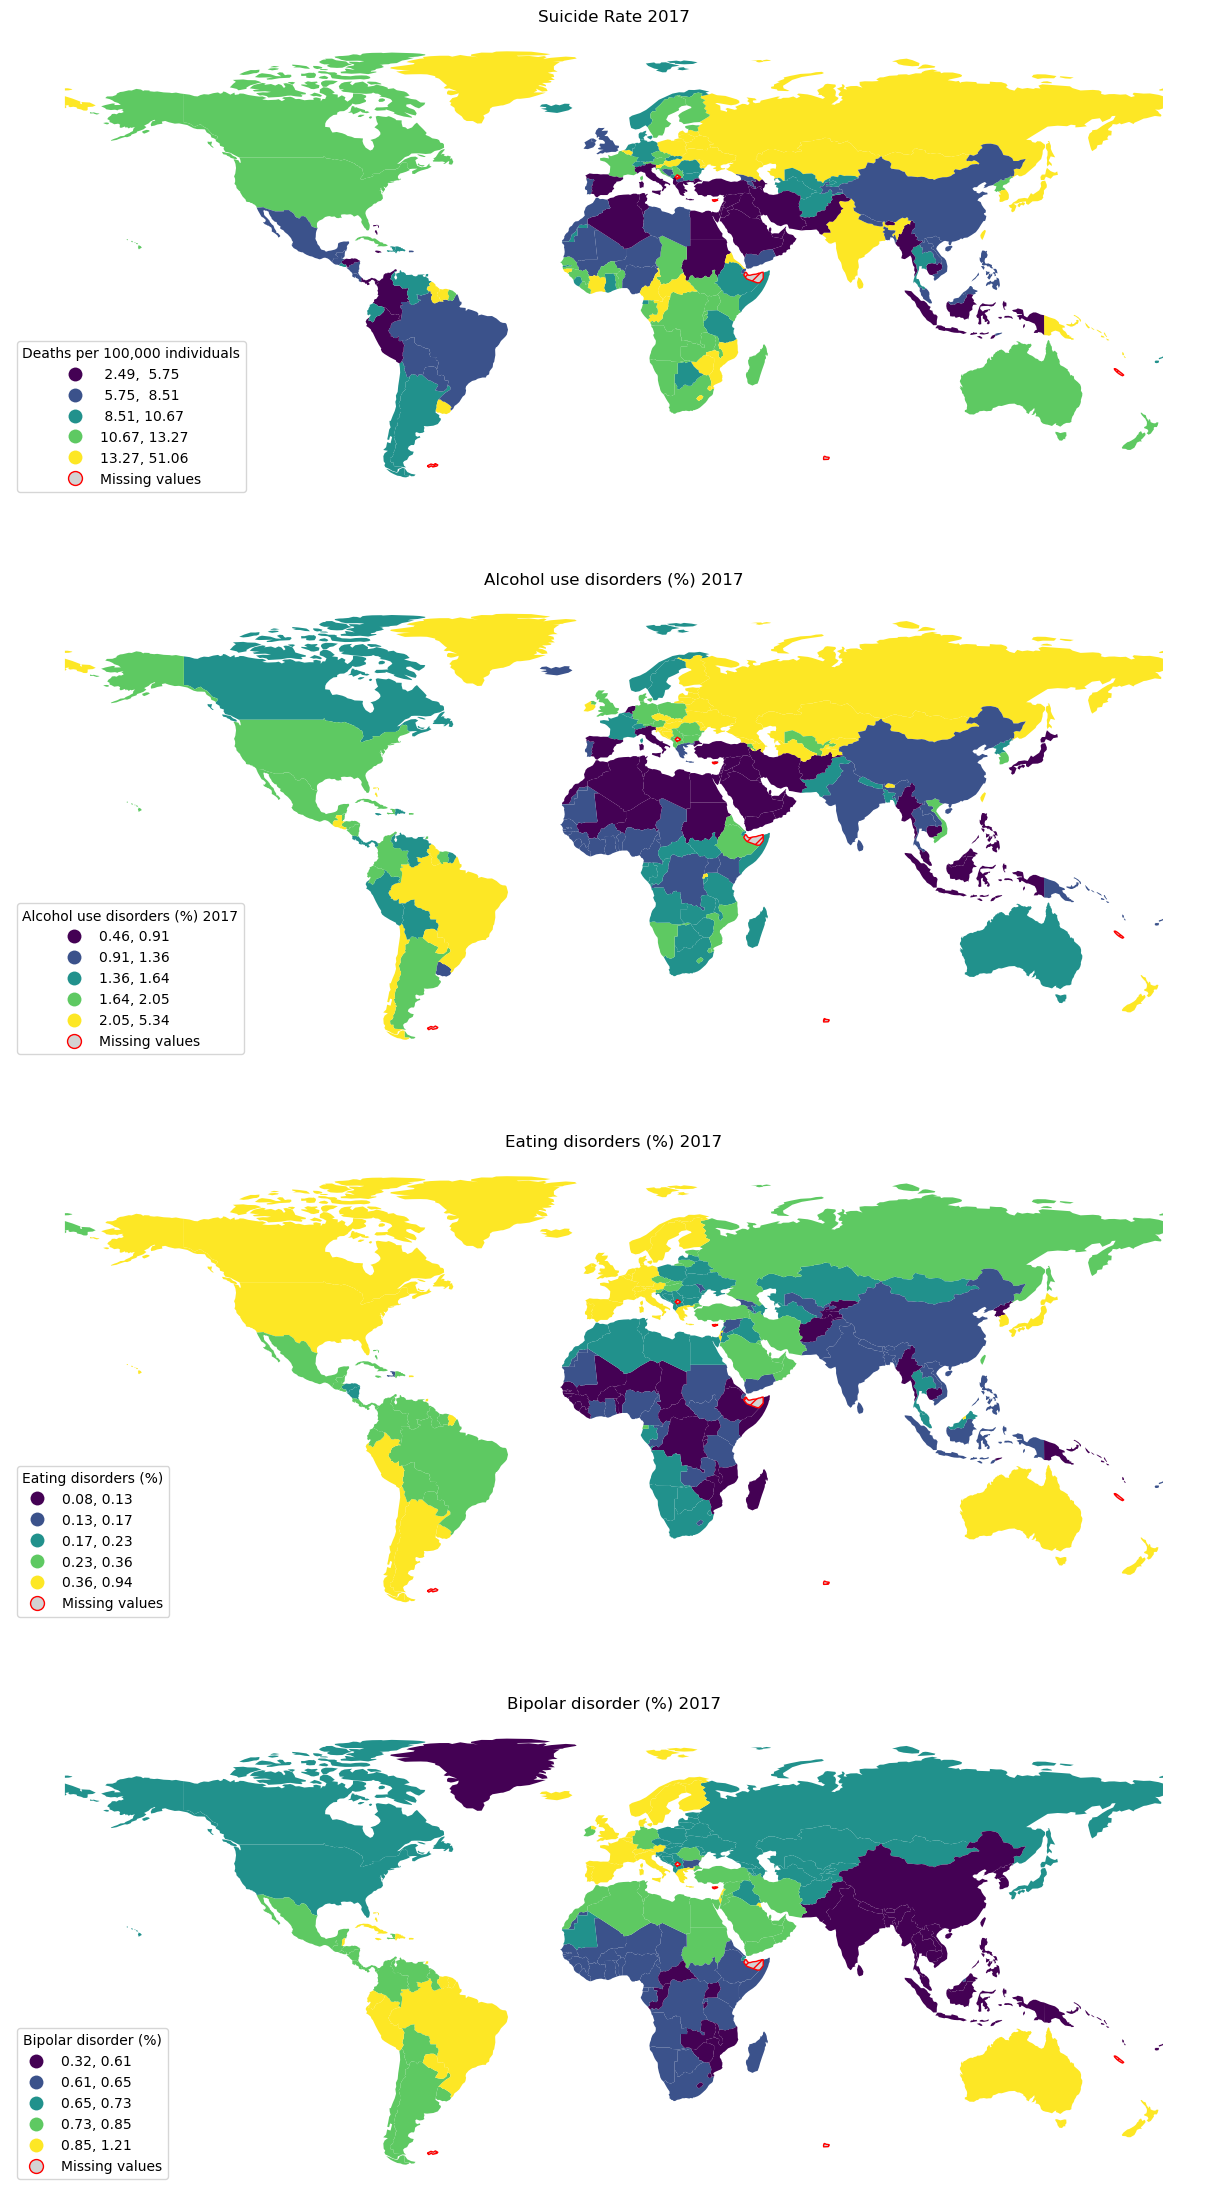

In [42]:
img = tablegeo[(tablegeo.name!="Antarctica")];  #remoce Antarctica

fig, ax = plt.subplots(4, 1, figsize= (25,28))


img.plot(column='Suicide rate (deaths per 100,000 individuals)', ax=ax[0], legend=True, scheme="quantiles", legend_kwds={'loc':'lower left', 'title':'Deaths per 100,000 individuals'}, missing_kwds={
        "color": "lightgray",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    });
ax[0].set_axis_off()
ax[0].set_title('Suicide Rate 2017');

img.plot(column='Alcohol use disorders (%)', ax=ax[1], legend=True, scheme="quantiles", legend_kwds={'loc':'lower left', 'title':'Alcohol use disorders (%) 2017'}, missing_kwds={
        "color": "lightgray",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    });
    
ax[1].set_axis_off()
ax[1].set_title('Alcohol use disorders (%) 2017');

img.plot(column='Eating disorders (%)', ax=ax[2], legend=True, scheme="quantiles", legend_kwds={'loc':'lower left', 'title':'Eating disorders (%)'}, missing_kwds={
        "color": "lightgray",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    });
    
ax[2].set_axis_off()
ax[2].set_title('Eating disorders (%) 2017');

img.plot(column='Bipolar disorder (%)', ax=ax[3], legend=True, scheme="quantiles", legend_kwds={'loc':'lower left', 'title':'Bipolar disorder (%)'}, missing_kwds={
        "color": "lightgray",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    });
    
ax[3].set_axis_off()
ax[3].set_title('Bipolar disorder (%) 2017');


Our last question is: which continents have more mental disorders? 

In [43]:
tablegeo[['continent','Schizophrenia (%)', 'Bipolar disorder (%)', 'Eating disorders (%)',
       'Anxiety disorders (%)', 'Drug use disorders (%)', 'Depression (%)',
       'Alcohol use disorders (%)']].groupby('continent').mean().dropna().mean(axis=1).sort_values(ascending = False)

continent
Europe           1.759339
South America    1.741655
Oceania          1.728453
North America    1.676041
Asia             1.501205
Africa           1.451680
dtype: float64

This table shows us that Europe is continent with highest percentage of mental disorder. To better visualize this let's plot the following graph: 

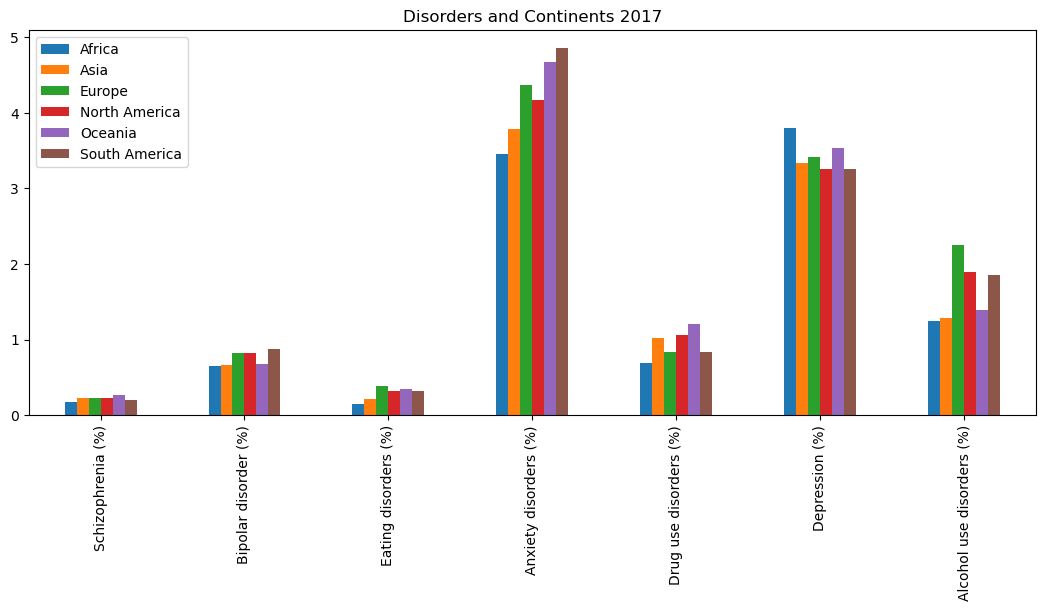

In [44]:
tablegeo[['continent','Schizophrenia (%)', 'Bipolar disorder (%)', 'Eating disorders (%)',
       'Anxiety disorders (%)', 'Drug use disorders (%)', 'Depression (%)',
       'Alcohol use disorders (%)']].groupby('continent').mean().dropna().transpose().plot.bar(title = 'Disorders and Continents 2017', figsize = (13,5))
plt.legend(loc= 'upper left');


Of course that this result doesn't prove that Europe has the highest percentage of mental disorders. The reason for that is the existence of the hidden variables that we mentioned previously.